In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import math
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn import metrics
from random import shuffle

In [2]:
from random_dataset import create_random_dataset
from evolutionary_algorithm import EA
from greedy_algorithm import GreedyAlgorithm
from neg_sel import NegativeSelection, load_data

# Peptides

In [3]:
sampled_peptides_data_dir = "./data/sampled/"
peptides_data_dir = "./data/languages/english/"

self1_data = pd.read_csv(peptides_data_dir + "english_6_train.txt", header=None)

self1_data

,0
0,chapte
1,r_loom
2,ings_c
3,all_me
4,_ishma
...,...
191713,ren_on
191714,ly_fou
191715,nd_ano
191716,ther_o


## Random Sampling

In [5]:
random_dataset = create_random_dataset(df=self1_data[:10000], n=3600, seed=42)

random_dataset_list = random_dataset[0].to_list()
random_dataset_list

['g_bed_',
 'nd_of_',
 'and_jo',
 'd_desi',
 'ing_no',
 'chor_s',
 'aco_wh',
 'attres',
 'small_',
 '_needl',
 'r_coff',
 'were_r',
 'ump_ag',
 'yond_m',
 '_indee',
 '_liabl',
 'loys_t',
 '_skyla',
 'ort_or',
 'thank_',
 'arpoon',
 'ent_wh',
 'ittle_',
 'from_s',
 'it_of_',
 'asantl',
 's_proc',
 'nty_gr',
 'ng_lik',
 '_done_',
 'tter_s',
 'ness_a',
 'nder_t',
 '_was_n',
 'f_him_',
 'rs_tha',
 'come_j',
 'of_a_d',
 'h_it_w',
 'parade',
 '_some_',
 'he_wat',
 'with_h',
 'e_the_',
 'sounds',
 'rld_it',
 '_have_',
 '_nervo',
 'being_',
 '_stree',
 'ed_and',
 'lookin',
 'ould_a',
 '_ee_be',
 '_poor_',
 'ng_int',
 'gainst',
 'o_curt',
 'came_t',
 'les_al',
 'e_been',
 'n_deli',
 'ought_',
 'preven',
 'sfacti',
 'uldn_t',
 'outer_',
 'd_hand',
 'e_slep',
 't_poor',
 'm_into',
 'why_di',
 'ere_pl',
 'feet_o',
 'her_th',
 '_be_af',
 'es_to_',
 'in_my_',
 '_when_',
 'ber_mu',
 'n_roun',
 'a_salt',
 'r_but_',
 'ney_wi',
 'ool_as',
 'be_in_',
 'y_besm',
 'here_a',
 '_lost_',
 'the_la',
 'ese_co',

In [ ]:
with open("./data/languages/english/english_random.txt", "w") as f:
    for item in random_dataset_list:
        f.write(f"{item}\n")

## Peptide Preperations and Fitness Function

In [4]:
peptides = self1_data[0].tolist()
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)


def compute_Fpep(peptide, position_freqs):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))


fpep_scores = [compute_Fpep(p, position_freqs) for p in peptides]

fpep_scores

[0.37046946564885497,
 0.34214503816793895,
 0.31243893129770994,
 0.45534351145038165,
 0.308206106870229,
 0.39288167938931295,
 0.3587213740458015,
 0.3714351145038168,
 0.3233931297709924,
 0.327793893129771,
 0.4612251908396947,
 0.22970610687022902,
 0.36521374045801525,
 0.46572519083969466,
 0.41359541984732817,
 0.27366030534351143,
 0.4122862595419848,
 0.3048435114503817,
 0.6128358778625954,
 0.4230801526717557,
 0.4459923664122137,
 0.38794656488549617,
 0.36055725190839694,
 0.35133206106870224,
 0.3815496183206107,
 0.43906870229007633,
 0.5297709923664122,
 0.31613358778625955,
 0.3573053435114504,
 0.36460305343511445,
 0.5421106870229008,
 0.2218053435114504,
 0.5223931297709924,
 0.448469465648855,
 0.5231259541984733,
 0.4818015267175572,
 0.28482061068702286,
 0.42503816793893134,
 0.26506106870229007,
 0.4940190839694657,
 0.4010687022900763,
 0.3785419847328244,
 0.3408053435114504,
 0.4888740458015267,
 0.3559465648854962,
 0.514618320610687,
 0.2693091603053435

## Greedy Algorithm

In [ ]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY"

motifs = ["".join(motif) for motif in product(amino_acids, repeat=6)]

print(f"Total number of motifs: {len(motifs)}")

In [5]:
len(self1_data[0].tolist())

262000

In [ ]:
%%time
# greedy_optimizer = GreedyAlgorithm(
#     peptides=self1_data[0].tolist(),
#     motifs=motifs,
#     t=3,
#     seed=42
# )

# for now, let's limit the lists due to computational constraints
greedy_optimizer = GreedyAlgorithm(peptides=self1_data[0].tolist()[0:200], motifs=motifs[0:200000], t=3, seed=42)
self1_optimized_data = greedy_optimizer.run()
self1_optimized_data

In [ ]:
print(f"Size of greedily optimized data set: {len(self1_optimized_data)}")

In [ ]:
with open(sampled_peptides_data_dir + "self1_6mers_greedy.txt", "w") as f:
    for item in self1_optimized_data:
        f.write(f"{item}\n")

# Improved Evolutionary Algorithm

Counting frequencies per position
COnverting counts to frequencies
Computing aa frequencies
Compute features
Scaling
Count exchangeability
Running EA
Gen 1: Best = -0.05029380966885941, Avg = -2.943615363718382e-05
Gen 101: Best = -0.14322415240628686, Avg = -0.10995728994255628
Gen 201: Best = -0.1467087588537721, Avg = -0.11071634437265303
Gen 301: Best = -0.14570466812465732, Avg = -0.10661831640813521
Gen 401: Best = -0.1488352831784378, Avg = -0.1108767242743756


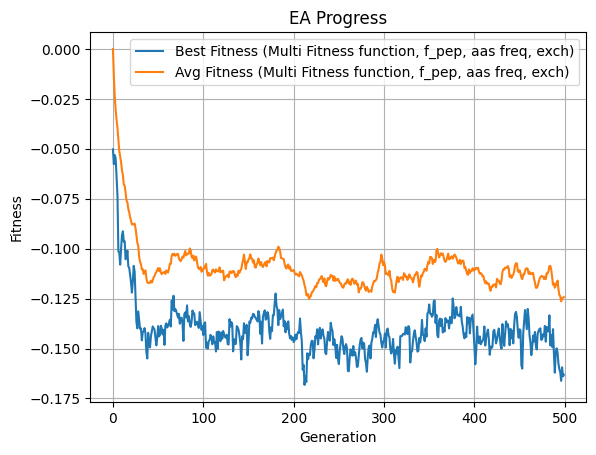

['EEDIHR',
 'DLHEPP',
 'AAHLKG',
 'LGALLA',
 'MWFLLT',
 'QLHFLA',
 'YSIAYI',
 'KAMPLP',
 'QEEWYL',
 'INSQIS',
 'DEGLIT',
 'CKYQFE',
 'DRNQPE',
 'IFHEVL',
 'WTHVGP',
 'LSLLEP',
 'DVIICL',
 'ACIIWC',
 'IDMTSY',
 'FLQHFA',
 'LGMPDT',
 'APEMPL',
 'IFAICW',
 'ARGGSF',
 'INLALL',
 'NICYNA',
 'WKQVQF',
 'AATEHL',
 'MHIHLC',
 'VFQVAY',
 'AAAPPE',
 'QDYTVW',
 'VYYMLE',
 'NEVLDF',
 'TQVDPI',
 'PLLFQL',
 'LNYLMP',
 'VDAVGT',
 'ISEFSF',
 'LHTVMY',
 'RYFDWL',
 'FGYFVD',
 'EEGFQQ',
 'KKELVQ',
 'FWKNLS',
 'APPQFT',
 'LFVNQT',
 'IVAYLV',
 'GNLDIT',
 'LFWENE',
 'FEEGLN',
 'FGRSSE',
 'HYILQE',
 'FLSMFL',
 'PAVGWG',
 'YAWEHI',
 'VGAEFF',
 'GPRRVP',
 'DSAQRS',
 'CAACCL',
 'GLNFYG',
 'VSVLVG',
 'MAQYQQ',
 'FPLDMG',
 'FFSNFS',
 'DPARVN',
 'VCVDGI',
 'VESPWR',
 'GYMSQE',
 'FHPIEP',
 'IAGYYR',
 'LLSLPL',
 'AVFIYY',
 'TGPTSP',
 'LNVLAF',
 'FYGRFL',
 'LLAPSS',
 'ALGCLA',
 'MILCGN',
 'WNFLHT',
 'LGLLGT',
 'LADVAI',
 'YGALTF',
 'REASEL',
 'VAGVVS',
 'QHGVVS',
 'PTFTFR',
 'VVTCYL',
 'GKYFCQ',
 'LVPAFL',
 'SERIPR',

In [6]:
peptides = self1_data[0].tolist()  # [0:200] test
shuffle(peptides)
peptides = peptides[:10000]
peptide_length = len(peptides[0])

position_counts = [defaultdict(int) for _ in range(peptide_length)]

# count frequencies per position
print("Counting frequencies per position")
for peptide in peptides:
    for i, aa in enumerate(peptide):
        position_counts[i][aa] += 1

# convert counts to frequencies
print("COnverting counts to frequencies")
position_freqs = []
for pos in position_counts:
    total = sum(pos.values())
    pos_freq = {aa: count / total for aa, count in pos.items()}
    position_freqs.append(pos_freq)


def compute_Fpep(peptide):
    return sum(position_freqs[i].get(aa, 0) for i, aa in enumerate(peptide))


def compute_aa_frequency_scores(peptides):
    aa_counts = defaultdict(int)
    total_aa = 0

    for p in peptides:
        for aa in p:
            aa_counts[aa] += 1
            total_aa += 1

    aa_freqs = {aa: count / total_aa for aa, count in aa_counts.items()}

    def score(peptide):
        return sum(aa_freqs[aa] for aa in peptide)

    return [score(p) for p in peptides]


print("Computing aa frequencies")
aa_freq_scores = compute_aa_frequency_scores(peptides)

print("Compute features")
feature_vectors: list[list[int | float]] = []
for i, peptide in enumerate(peptides):
    fpep = compute_Fpep(peptide)
    aa = aa_freq_scores[i]
    feature_vectors.append([fpep, aa])

print("Scaling")
scaler = StandardScaler()
feature_vectors = scaler.fit_transform(feature_vectors)


def affinity(motif: str, peptide: str) -> int:
    max_adjacent = 0
    current = 0
    for m, p in zip(motif, peptide):
        if m == p:
            current += 1
            if current > max_adjacent:
                max_adjacent = current
        else:
            current = 0
    return max_adjacent


def compute_exchangeability(subset_peptides, t):
    n = len(subset_peptides)
    scores = np.zeros(n, dtype=int)

    for i in range(n):
        for j in range(n):
            if i != j and affinity(subset_peptides[i], subset_peptides[j]) >= t:
                scores[i] += 1

    return scores


t = 3  # threshold affinity
print("Count exchangeability")
raw_exchangeability_scores = compute_exchangeability(peptides, t).reshape(-1, 1)
global_exchangeability_scores = scaler.fit_transform(raw_exchangeability_scores).flatten()


# exchangeability_mean_global = np.mean(compute_exchangeability(peptides, t))
def composite_fitness(indices):
    subset_vectors = feature_vectors[indices]

    fpep_mean = np.mean(subset_vectors[:, 0])
    aa_mean = np.mean(subset_vectors[:, 1])

    exchangeability_scores = [global_exchangeability_scores[i] for i in indices]  # get all scores of the indices
    exchangeability_mean = np.mean(exchangeability_scores)

    return 1 * fpep_mean + 1 * aa_mean + 1 * exchangeability_mean


print("Running EA")
m_ea = EA(data=feature_vectors, N=100, sigma=6125, K=2, p=0.1, mu=0.02, T=500, f=composite_fitness, seed=42)
multi_best_individual, multi_best_fitness, multi_fitness_avg, multi_fitness_best = m_ea.run()

plt.plot(multi_fitness_best, label="Best Fitness (Multi Fitness function, f_pep, aas freq, exch)")
plt.plot(multi_fitness_avg, label="Avg Fitness (Multi Fitness function, f_pep, aas freq, exch)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("EA Progress")
plt.legend()
plt.grid(True)
plt.show()

multi_optimal_peptides = [peptides[i] for i in multi_best_individual]
multi_optimal_peptides

In [7]:
print(len(multi_optimal_peptides))

6125


In [8]:
with open(sampled_peptides_data_dir + "self1_6mers_ea_final.txt", "w") as f:
    for item in multi_optimal_peptides:
        f.write(f"{item}\n")

## Negative Selection

In [10]:
r_start = 1
r_stop = 6

ns = NegativeSelection(
    "/data/sampled/6mers.alpha", "./data/sampled/self1_6mers_ea_final.txt", r_start=r_start, r_stop=r_stop, n=6
)

normal_path = "./data/peptides/self2-6mers.txt"
anomalous_path = "./data/peptides/"
result_path = "./data/results/"

ns.run(normal_path, result_path, "ea")
# ns.run(anomalous_path, result_path, "random")

In [11]:
foreigns = ["ebola", "hepb", "hiv"]
for foreign in foreigns:
    anomalous_path = "./data/peptides/" + foreign + "-6mers.txt"
    ns.run(anomalous_path, result_path, "ea")

### Calculate metrics of negative selection

In [12]:
def preprocess_data(data: pd.DataFrame, r: int):
    anomalous_data = data[data["anomalous"] == 1]
    sensitivity = len(anomalous_data[anomalous_data["score"] > r]) / len(anomalous_data)

    non_anomalous_data = data[data["anomalous"] == 0]
    specificity = len(non_anomalous_data[non_anomalous_data["score"] < r]) / len(non_anomalous_data)

    data["y"] = data["score"] > r

    return anomalous_data, non_anomalous_data, data


def caclulate_roc_auc(data):
    fpr, tpr, thresholds = metrics.roc_curve(data["anomalous"], data["score"])
    auc = metrics.roc_auc_score(data["anomalous"], data["score"])
    roc = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)

    return auc, roc

#### Roc plots

/home/vaggelis_spithas/Documents/ru/naco/projects/NaCo_Project/.naco310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vaggelis_spithas/Documents/ru/naco/projects/NaCo_Project/.naco310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vaggelis_spithas/Documents/ru/naco/projects/NaCo_Project/.naco310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division`

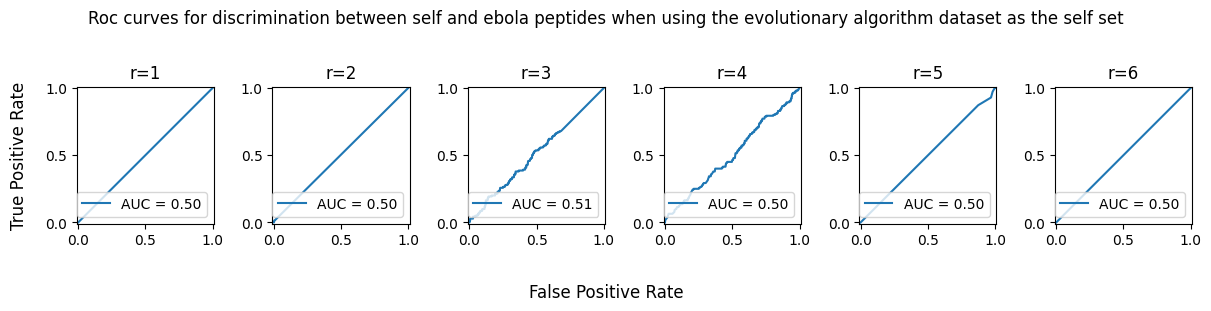

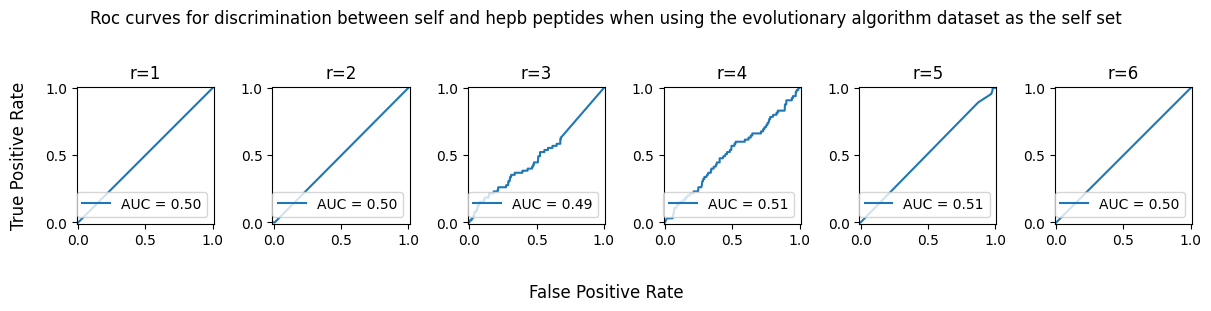

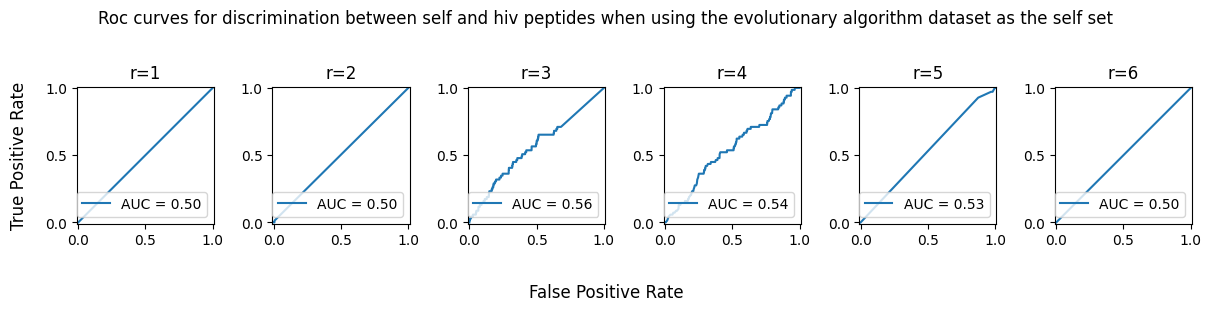

In [16]:
pd.set_option("future.no_silent_downcasting", True)  # opt-in for future behavior of replace

for foreign in foreigns:
    res_dir = "./data/results/"
    anomalous_path = "./data/peptides/" + foreign + "-6mers.txt"

    fig, ax = plt.subplots(1, r_stop, figsize=(12, 3), constrained_layout=True)
    fig.suptitle(
        f"Roc curves for discrimination between self and {foreign} peptides when using the evolutionary algorithm dataset as the self set"
    )
    fig.supxlabel("False Positive Rate")
    fig.supylabel("True Positive Rate")

    acc_list = []
    err_rate_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    for r in range(r_start, r_stop + 1):
        anomalous_data = load_data(anomalous_path, r, res_dir, 1, "ea")
        normal_data = load_data(normal_path, r, res_dir, 0, "ea")
        data = pd.concat([anomalous_data, normal_data])

        _, _, data = preprocess_data(data, r)
        # display(data.head())

        auc, roc = caclulate_roc_auc(data)
        axis = ax[r - 1]
        roc.plot(ax=axis)
        axis.set_xlabel("")
        axis.set_ylabel("")
        axis.set_title(f"r={r}")

        y_true = data["anomalous"].to_list()
        y_pred = data["y"].replace({True: 1, False: 0}).to_list()
        acc = metrics.accuracy_score(y_true, y_pred)
        err_rate = 1 - acc

        f1 = metrics.f1_score(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred)
        recall = metrics.recall_score(y_true, y_pred)

        acc_list.append(acc)
        err_rate_list.append(err_rate)
        f1_list.append(f1)
        precision_list.append(precision)
        recall_list.append(recall)

#### Accuracy and Error Rate plots

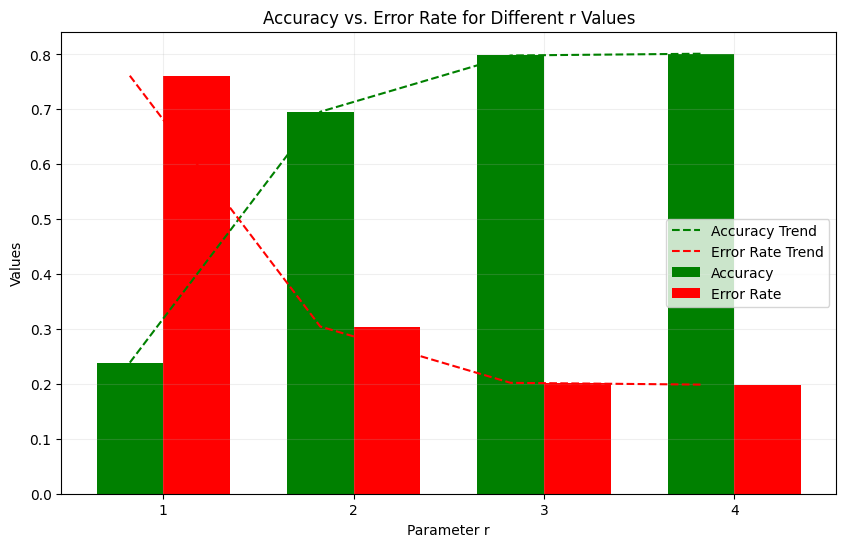

In [ ]:
r_values = [r for r in range(r_start, r_stop + 1)]
bar_width = 0.35
x = np.arange(len(r_values))

plt.figure(figsize=(10, 6))

plt.bar(x, acc_list, bar_width, label="Accuracy", color="green")
plt.bar(x + bar_width, err_rate_list, bar_width, label="Error Rate", color="red")

# Add trend lines for accuracy and error rates
# Use moving average for the trend line (smooth line)
window = 1  # Number of points to average over
accuracy_trend = np.convolve(acc_list, np.ones(window) / window, mode="valid")
error_trend = np.convolve(err_rate_list, np.ones(window) / window, mode="valid")

plt.plot(x[window - 1 :], accuracy_trend, "g--", label="Accuracy Trend")
plt.plot(x[window - 1 :], error_trend, "r--", label="Error Rate Trend")

plt.xlabel("Parameter r")
plt.ylabel("Values")
plt.title("Accuracy vs. Error Rate for Different r Values")
plt.xticks(x + bar_width / 2, r_values)  # Center the x-tick labels
plt.legend()
plt.grid(True, alpha=0.2)

plt.show()

#### F1, Precision and Recall Plots

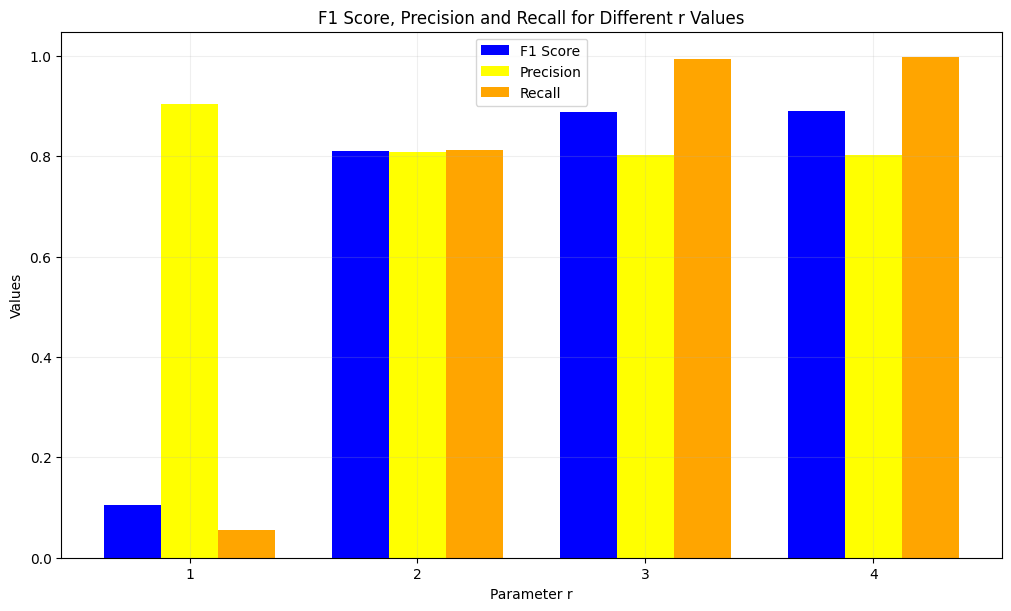

In [ ]:
bar_width = 0.25

# plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(layout="constrained", figsize=(10, 6))

ax.bar(x, f1_list, bar_width, label="F1 Score", color="blue")
ax.bar(x + bar_width, precision_list, bar_width, label="Precision", color="yellow")
ax.bar(x + 2 * bar_width, recall_list, bar_width, label="Recall", color="orange")


ax.set_xlabel("Parameter r")
ax.set_ylabel("Values")
ax.set_title("F1 Score, Precision and Recall for Different r Values")
ax.legend()
ax.set_xticks(x + bar_width, r_values)
ax.grid(True, alpha=0.2)

plt.show()